In [5]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 9 May 2023
# Description:
#     this script obtain the previously saved 1500m isobath contour variables, 
#     and calculate the cross-shelf heat transport estimates


In [6]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [7]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
temp = ds.variables["temp"] 
salt = ds.variables["salt"]
shflux = ds.variables["shflux"] 
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"] 
Huon = ds.variables["Huon"] 

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
print("Vtransform=2")
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice

ds.close()


Vtransform=2
CPU times: user 3.72 s, sys: 1.51 s, total: 5.23 s
Wall time: 3.31 s


In [9]:
# load 1500m-isobath contour:

vars=['X_contour', 'Y_contour', 'H_contour', 'Contour_mask','Contour_mask_above','Mask_shelf2','Mask_x_transport', 
      'Mask_x_transport_Ugrd','Mask_x_transport_numbered_Ugrd','Mask_y_transport','Mask_y_transport_Vgrd',
      'Mask_y_transport_numbered_Vgrd','Contour_ordering', 'Mask_x_numbered_1d','Mask_y_numbered_1d']

outdir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
# outdir = '/home/581/fbd581/cross_contour_tmp/'

ds = xr.open_dataset(outdir + 'WAOM10extend_cross-1500m_vars4OHB.nc')
    

In [10]:
print(ds)

<xarray.Dataset>
Dimensions:                         (Ncontour: 1954, eta_rho: 560, xi_rho: 630,
                                     eta_u: 560, xi_u: 629, eta_v: 559,
                                     xi_v: 630, contour_index: 2588)
Dimensions without coordinates: Ncontour, eta_rho, xi_rho, eta_u, xi_u, eta_v,
                                xi_v, contour_index
Data variables: (12/15)
    X_contour                       (Ncontour) float32 ...
    Y_contour                       (Ncontour) float32 ...
    H_contour                       (Ncontour) float32 ...
    Contour_mask                    (eta_rho, xi_rho) float32 ...
    Contour_masked_above            (eta_rho, xi_rho) float32 ...
    Mask_shelf2                     (eta_rho, xi_rho) float32 ...
    ...                              ...
    Mask_x_transport_numbered_Ugrd  (eta_u, xi_u) float32 ...
    Mask_y_transport_Vgrd           (eta_v, xi_v) float32 ...
    Mask_y_transport_numbered_Vgrd  (eta_v, xi_v) float32 ...
    M

In [11]:
# convert temp to DataArray to extract values along contour:
months=np.arange(0,73)*(5/30.41667)

coordinatesT=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))
temp_xr = xr.DataArray(temp, coords = coordinatesT, dims = ['ocean_time','s_rho','eta_rho', 'xi_rho'])

# rename dimensions as simply eta/xi
temp_xr = temp_xr.rename({'eta_rho': 'eta','xi_rho': 'xi'})


In [25]:
## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.
zlen = 31

temp_along_contour = np.empty((zlen,len(ds.Contour_ordering)))

temp_xr_avg = temp_xr.mean(dim='ocean_time')

# Fabio: need to loop through z-levels  
zz=1

temp_tmp = temp_xr_avg[zz,:]

# stack transports into 1d and drop any points not on contour:
x_temp_1d_tmp = temp_tmp.stack(contour_index = ['eta', 'xi'])
x_temp_1d_tmp = x_temp_1d_tmp.where(ds.Maask_x_numbered_1d>0, drop = True)
# y_temp_1d_tmp = temp_tmp.stack(contour_index = ['eta', 'xi'])
# y_temp_1d_tmp = y_temp_1d_tmp.where(ds.Mask_y_numbered_1d>0)#, drop = True)

# # combine all points on contour:
# temp_along_contour_tmp = xr.concat((x_temp_1d_tmp, y_temp_1d_tmp), dim = 'contour_index')
# temp_along_contour_tmp = temp_along_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
# temp_along_contour_tmp = temp_along_contour_tmp.sortby(ds.Contour_ordering)
# temp_along_contour_tmp.coords['contour_index'] = contour_index_array
# temp_along_contour_tmp = temp_along_contour_tmp.load()
    
# temp_along_contour[zz,:] = temp_along_contour_tmp
# del temp_along_contour_tmp
    

ValueError: cannot reindex or align along dimension 'contour_index' because of conflicting dimension sizes: {352800, 2588} (note: an index is found along that dimension with size=352800)

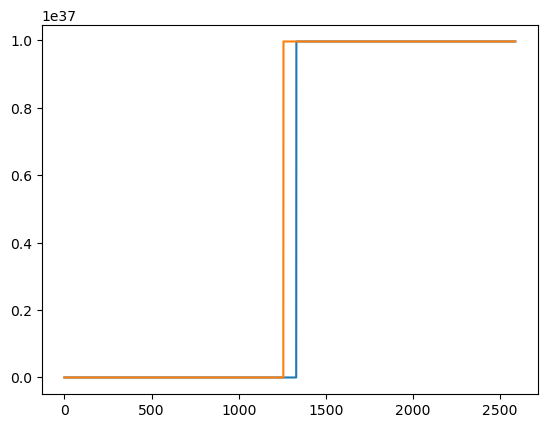

In [23]:
plt.plot(ds.Mask_x_numbered_1d)
plt.plot(ds.Mask_y_numbered_1d)
plt.show()

In [17]:
x_temp_1d_tmp.contour_index

<xarray.DataArray 'contour_index' (contour_index: 352800)>
array([(0, 0), (0, 1), (0, 2), ..., (559, 627), (559, 628), (559, 629)],
      dtype=object)
Coordinates:
    s_rho          int64 1
  * contour_index  (contour_index) object MultiIndex
  * eta            (contour_index) int64 0 0 0 0 0 0 ... 559 559 559 559 559 559
  * xi             (contour_index) int64 0 1 2 3 4 5 ... 624 625 626 627 628 629

In [ ]:
# takes too long, change it for only annual average

## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.
zlen = 31

temp_along_contour = np.empty((zlen,len(ds.Contour_ordering)))

temp_xr_avg = temp_xr.mean(dim='ocean_time')

# Fabio: need to loop through z-levels  
for zz in range(0,zlen):
    
    temp_tmp = temp_xr_avg[zz,:]

# stack transports into 1d and drop any points not on contour:
    x_temp_1d_tmp = temp_tmp.stack(contour_index = ['eta', 'xi'])
    x_temp_1d_tmp = x_temp_1d_tmp.where(ds.Mask_x_numbered_1d>0)#, drop = True)
    y_temp_1d_tmp = temp_tmp.stack(contour_index = ['eta', 'xi'])
    y_temp_1d_tmp = y_temp_1d_tmp.where(ds.Mask_y_numbered_1d>0)#, drop = True)

# combine all points on contour:
    temp_along_contour_tmp = xr.concat((x_temp_1d_tmp, y_temp_1d_tmp), dim = 'contour_index')
    temp_along_contour_tmp = temp_along_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
    temp_along_contour_tmp = temp_along_contour_tmp.sortby(ds.Contour_ordering)
    temp_along_contour_tmp.coords['contour_index'] = contour_index_array
    temp_along_contour_tmp = temp_along_contour_tmp.load()
    
    temp_along_contour[zz,:] = temp_along_contour_tmp
    del temp_along_contour_tmp
    
    

In [ ]:
705600/1331

In [ ]:
705600/1257